# Visualizing River Network

In [1]:
%matplotlib inline

In [2]:
# =========== Load python modules =========== #
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from matplotlib import colors as c
from cartopy.io.srtm import srtm_composite
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

#=================================#
This script is used to plot a river network, showing river width through the width of line segment and another river-related variable, e.g., stream temperature, through the color of line segment. 

Note: this script is design to plot for grid-based river network. 


In [3]:
#===============define functions===============#
def find_downstream_grid_arcgis(flow_dir, lat_pre, lon_pre, delta):
    '''
    This function is used to find downstream grid cell based on the flow direction number of that grid cell.
    Meanwhile, this is for Arc GIS format.
    Input: 1) flow_dir: flow direction number
           2) lat_pre: latitude for current grid cell
           3) lon_pre: longitude for current grid cell
           4) delta:   grid cell size
    output:
           [lat_post, lon_post]
    '''

    if flow_dir in [1, 2, 128]:
        lon_post = lon_pre + delta
    else:
        if flow_dir in [8, 16, 32]:
            lon_post = lon_pre - delta
        else:
            lon_post = lon_pre

    if flow_dir in [2, 4, 8]:
        lat_post = lat_pre - delta
    else:
        if flow_dir in [32, 64, 128]:
            lat_post = lat_pre + delta
        else:
            lat_post = lat_pre

    if flow_dir == 0:
        lat_post = lat_pre
        lon_post = lon_pre

    return [lat_post, lon_post]

In [4]:
def cal_width(flow):
    '''
    Calculate width based on flow
    '''
    if flow<=1:
        width=0.1
    else:
        width=np.log10(flow)
        
    return width

In [5]:
# ===============================================#
#              read in required data             #
# ===============================================#

# flow direction file in netCDF format
fdr_ds= xr.open_dataset('data/region6_fdr_udpate.nc')

# domain file in netCDF format
domain_ds = xr.open_dataset('data/domain.Tennessee.nc')
lat_domain_list=domain_ds.lat.values
lon_domain_list=domain_ds.lon.values

# resolution of grid
resolution = 1./8.

# mean annual streamflow in netCDF format
# Stream width is calculated based on streamflow
flow_mean = xr.open_dataset('data/mean_flow.nc')

# mean seasonal stream temperature in netCDF format
# river segment color is based on mean summer stream temperature
temp_mean = xr.open_dataset('data/mean_temp.nc')
temp_mean = temp_mean['T_stream']

In [6]:
# ===============================================#
#           generate required format             #
# ===============================================#

from_lon_list=[]
from_lat_list=[]
to_lon_list=[]
to_lat_list=[]
width_list=[]
temp_color_list=[]

# define the range of the colormap
vmax=30
vmin=12
norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)

for lat in lat_domain_list:
    for lon in lon_domain_list:
        # if this grid is within our domain
        if domain_ds.mask.sel(lat=lat,lon=lon)==1: 
            
            # find the latitude and longitude of downstream grid cell
            fdr=fdr_ds.flow_direction.sel(lat=lat,lon=lon)
            lat_post,lon_post=find_downstream_grid_arcgis(fdr,lat,lon,resolution)
            
            # find the streamflow 
            flow=float(flow_mean.streamflow.sel(lat=lat,lon=lon))
            
            # calculate width based on streamflow
            width=cal_width(flow)
            
            # find the stream temperature 
            temp=float(temp_mean.sel(lat=lat,lon=lon,month=6))
            
            # give color based on the stream temperature
            color=cmocean.cm.matter(norm(temp))
            
            # add to list
            from_lon_list.append(lon)
            from_lat_list.append(lat)
            to_lon_list.append(lon_post)
            to_lat_list.append(lat_post)
            width_list.append(width)
            temp_color_list.append(color)
            

In [7]:
# summarize it into a dataframe, which we will use it for plotting
plot_df=pd.DataFrame(np.transpose([from_lon_list,from_lat_list,
                                   to_lon_list,to_lat_list,
                                   width_list]),
                     columns=['from_lon','from_lat','to_lon','to_lat','width'])
plot_df['color']=temp_color_list

Text(0.5, 1.0, 'Mean summer stream temperature for Tennessee River Basin')

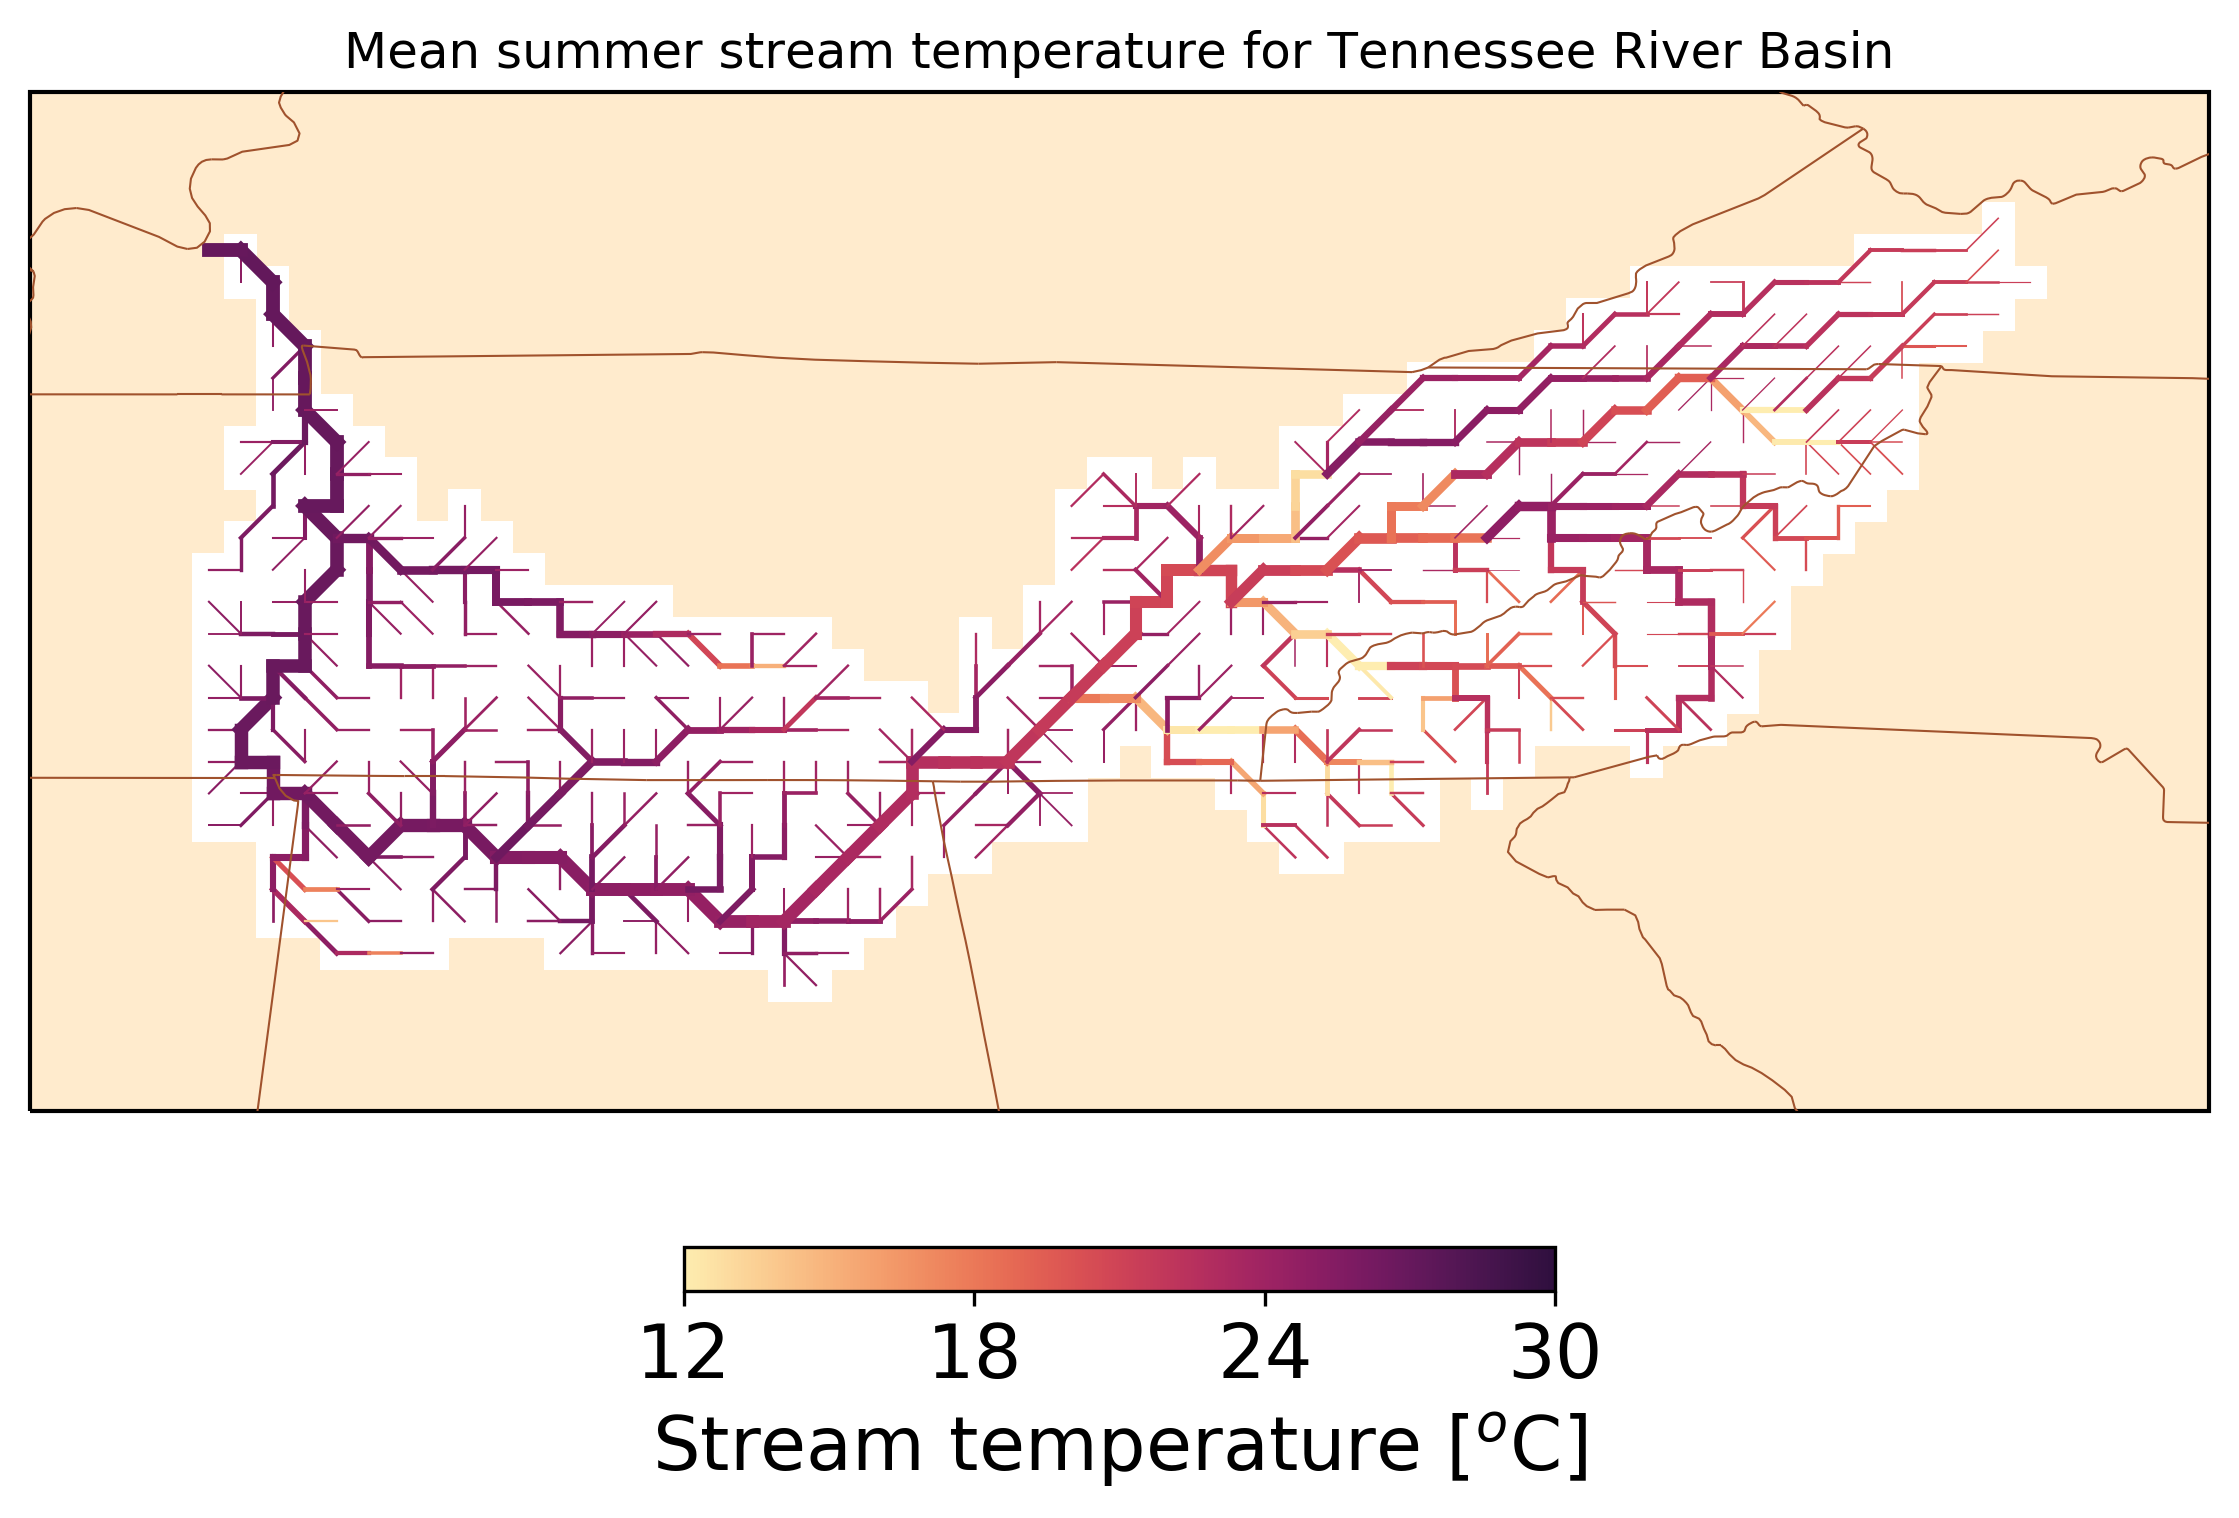

In [8]:
# ===============================================#
#                     Plotting                   #
# ===============================================#


fig = plt.figure(figsize=(15, 6), dpi=300)
ax = plt.subplot(111, projection=ccrs.PlateCarree())

# plotting backgroud
states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

country_bound = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_0_boundary_lines_land',
                   scale='10m',
                   facecolor='none')

coastline = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='coastline',
                   scale='10m',
                   facecolor='none')
river = cfeature.NaturalEarthFeature(
                   category='physical',
                   name='rivers_lake_centerlines',
                   scale='10m',
                   facecolor='none')

ax.add_feature(states_provinces, edgecolor='sienna', linewidth=0.5, zorder = 5)
ax.add_feature(coastline, edgecolor='black', zorder = 5)
ax.add_feature(cfeature.LAND,color='blanchedalmond')
ax.add_feature(cfeature.OCEAN, color='skyblue')
ax.add_feature(cfeature.LAKES,color='skyblue')
ax.add_feature(country_bound, edgecolor='black', zorder = 5)

# define the color of the mapping background
cmap_bg = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white"]*2)

# plot the domain
domain_ds.mask.plot.pcolormesh(add_colorbar=False, cmap=cmap_bg,vmax=2,vmin=0.95)

# plot the river network
for i in plot_df.index.values:
    plt.plot([plot_df['from_lon'].loc[i], plot_df['to_lon'].loc[i]],
             [plot_df['from_lat'].loc[i], plot_df['to_lat'].loc[i]],
             lw=plot_df['width'].loc[i],c=plot_df['color'].loc[i],zorder=5)

# generate colorbar
pcm = temp_mean.sel(month=6).plot.pcolormesh(cmap=cmocean.cm.matter, add_colorbar=False, 
                                             vmax=vmax,vmin=vmin, zorder=0)
cb = fig.colorbar(pcm, ax=ax, pad=0.1,shrink=0.25,
                  ticks=[12, 18, 24, 30],orientation='horizontal') 
cb.set_label('Stream temperature ['+r"$^o$"+'C]', fontsize=18)
cb.ax.tick_params(labelsize=18)

# add title
plt.title('Mean summer stream temperature for Tennessee River Basin')